# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # for image processing
from PIL import Image
import os
import random
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
from keras_tuner import RandomSearch
from tensorflow.keras.applications import VGG16


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt

In [2]:
random.seed(123)
warnings.filterwarnings('ignore')

## Data Exploration

In [3]:
healthy_filepath = "archive/Brain Tumor Data Set/Brain Tumor Data Set/Healthy"
unhealthy_filepath = "archive/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor"

healthy_count = len(os.listdir(healthy_filepath))
unhealthy_count = len(os.listdir(unhealthy_filepath))

print(f"Healthy Images: {healthy_count}, Unhealthy Images: {unhealthy_count}")

Healthy Images: 2087, Unhealthy Images: 2513


## Load Images

In [4]:
# standardize all of the images
def load_images_from_folder(folder, label, image_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        try: 
            img = cv2.imread(filepath)
            if img is not None: # if openCV can't read the image try with PIL
                img = Image.open(filepath)
                img = img.convert("RGB") # convert to RGB in case of grayscale or RGBA
                img = np.array(img)

            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
        
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue  # Skip unreadable images
            
    return images, labels

In [5]:
# create arrays for images and labels
healthy_images, healthy_labels = load_images_from_folder(healthy_filepath, label = 0)
unhealthy_images, unhealthy_labels = load_images_from_folder(unhealthy_filepath, label = 1)

## Image Preprocessing

In [6]:
X = np.array(healthy_images + unhealthy_images) / 255.0
y = np.array(healthy_labels + unhealthy_labels)

**X explained:**
    This helps normalize the pixel values from their original range of [0, 255] to [0,1]. Normalizing helps the model learn more efficiently and can lead to better training results since most neural networks work better with normalized data. 
    


In [7]:
# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=5,      # Smaller rotation range
    zoom_range=0.1,        # Small zoom to avoid losing details
    width_shift_range=0.05, # Small shifts to keep important features within the frame
    height_shift_range=0.05,
    fill_mode="nearest"
)


**Data Augmentation:** Is meant to help prevent overfitting. 
* Rotation Range: randomly rotates images up to 20 degress which helps the model gereralize to slightly rotated images.
* Zoom Range: randomly zooms in or out on images by up to 15% which helps the model learn to recognize images at different scales.
* Width Shift Range and Height Shift Range: Randomly shifts images horizontally and vertically by up to 20%. This helps the model generalize slightly to images that may not be perfectly centered.
* Shear Range: Shear transformation means essentially "slanting" the image by up to 15% which helps robustness with slight distortions.
* Fill Mode: Speicifies how to fill in new pixel values when shifting, zooming, or rotating an image. 

## Split Data

In [8]:
# Separate healthy and unhealthy data based on labels
X_healthy = X[y == 0]
X_unhealthy = X[y == 1]

# Step 1: Training Set - 60% of total data, balanced 50/50 between healthy and unhealthy
train_size_per_class = 540  # 540 healthy, 540 unhealthy
X_train = np.concatenate((X_healthy[:train_size_per_class], X_unhealthy[:train_size_per_class]))
y_train = np.array([0] * train_size_per_class + [1] * train_size_per_class)

# Step 2: Validation Set - 30% of total data, with an 80/20 split
val_size_healthy = 432  # 80% healthy
val_size_unhealthy = 108  # 20% unhealthy
X_val = np.concatenate((X_healthy[train_size_per_class:train_size_per_class + val_size_healthy], 
                        X_unhealthy[train_size_per_class:train_size_per_class + val_size_unhealthy]))
y_val = np.array([0] * val_size_healthy + [1] * val_size_unhealthy)

# Step 3: Testing Set - 10% of total data, with an 80/20 split
test_size_healthy = 144  # 80% healthy
test_size_unhealthy = 36  # 20% unhealthy
X_test = np.concatenate((X_healthy[train_size_per_class + val_size_healthy:train_size_per_class + val_size_healthy + test_size_healthy], 
                         X_unhealthy[train_size_per_class + val_size_unhealthy:train_size_per_class + val_size_unhealthy + test_size_unhealthy]))
y_test = np.array([0] * test_size_healthy + [1] * test_size_unhealthy)

# Verification
print("Training set:", len(X_train), len(y_train))  # Expected: 1080
print("Validation set:", len(X_val), len(y_val))    # Expected: 540
print("Testing set:", len(X_test), len(y_test))      # Expected: 180


Training set: 1080 1080
Validation set: 540 540
Testing set: 180 180


**Training Set (2760 Images):**
* We select the first 1380 healthy and the first 1380 unhealthy images to ensure a 50/50 split.

**Validation Set (1380 Images):**
* We select the next 1104 healthy images and 276 unhealthy images to achieve an 80/20 split.

**Testing Set (460 Images):**
* Finally, we select the next 368 healthy images and 92 unhealthy images to meet the 80/20 split.

# Model Building

In [9]:
model = Sequential([
    Input(shape=(128, 128, 3)),  # Define the input shape here
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
print(len(X_train), len(y_train))  # Ensure both are equal
print(len(X_val), len(y_val))


1080 1080
540 540


In [12]:
# Train the model using the data generator for training and the validation set directly
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20
)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.5263 - loss: 1.1788 - val_accuracy: 0.6204 - val_loss: 0.6479
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5746 - loss: 0.6528 - val_accuracy: 0.6370 - val_loss: 0.6070
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.6405 - loss: 0.6389 - val_accuracy: 0.7370 - val_loss: 0.4674
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.7078 - loss: 0.5590 - val_accuracy: 0.7333 - val_loss: 0.5013
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7609 - loss: 0.4958 - val_accuracy: 0.8056 - val_loss: 0.4339
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.7547 - loss: 0.4951 - val_accuracy: 0.7796 - val_loss: 0.4111
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.7820 - loss: 0.4982 - val_accuracy: 0.7370 - val_loss: 0.4711
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.7842 - loss: 0.4844 - val_accuracy: 0.

In [13]:
# get the testing accuracy and loss
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Testing Accuracy: ", test_accuracy)
print("Testing Loss: ", test_loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8951 - loss: 0.2504
Testing Accuracy:  0.9111111164093018
Testing Loss:  0.2375599592924118


In [14]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_round = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions

# Generate classification report and confusion matrix
print(classification_report(y_test, y_pred_round))
confusionMatrix = confusion_matrix(y_test, y_pred_round)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       144
           1       0.75      0.83      0.79        36

    accuracy                           0.91       180
   macro avg       0.85      0.88      0.87       180
weighted avg       0.92      0.91      0.91       180



## Visualize Confusion Matrix

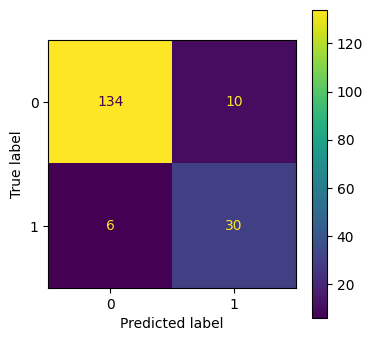

In [15]:
# plot the confusion matrix
confusionMatrixPlot = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix)
plt.figure(figsize=(4, 4))
confusionMatrixPlot.plot(ax=plt.gca())
plt.show()

## ROC Curve

In [16]:
# compute the AUC value
aucValue = roc_auc_score(y_test, y_pred)

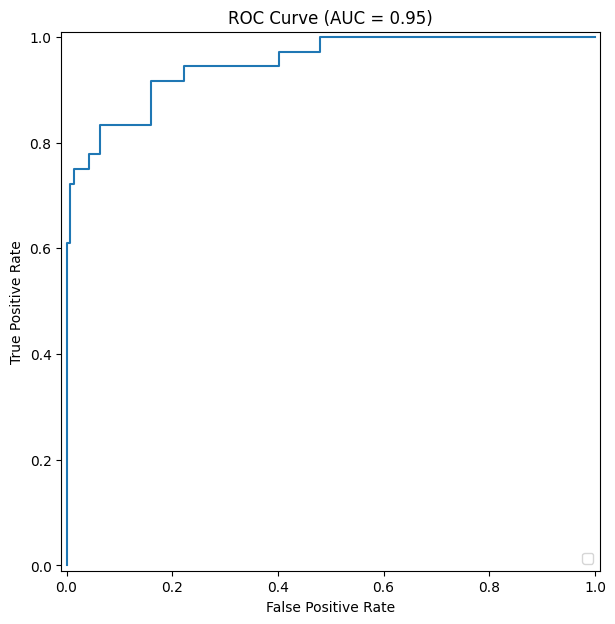

In [17]:
# plot the ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(7, 7))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(ax=plt.gca())
plt.title(f"ROC Curve (AUC = {aucValue:.2f})")
plt.show()

## Precision-Recall Curve

In [18]:
# compute the precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

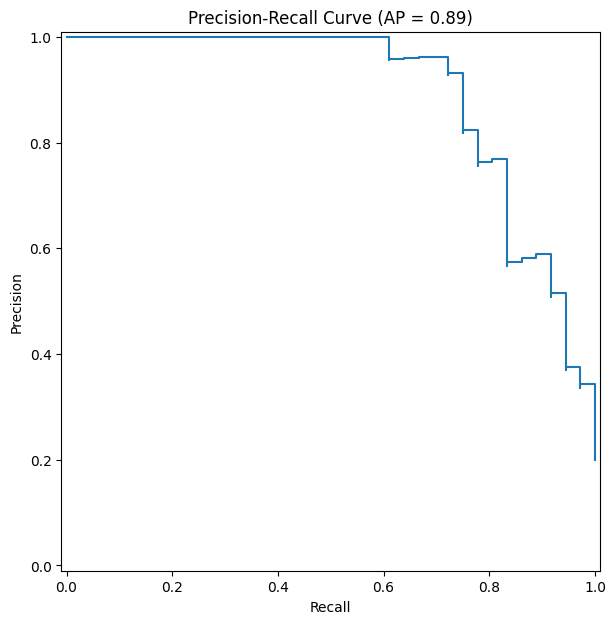

In [19]:
# plot the PRC
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(7, 7))
PRC_display = PrecisionRecallDisplay(precision= precision, recall=recall)
PRC_display.plot(ax=plt.gca())
plt.title(f"Precision-Recall Curve (AP = {average_precision:.2f})")
plt.show()